# WEB Madenciliği Dersi Proje Ödevi

* Fatma SERT
* 132230040

> **Bu projenin temel amacı**, Türkiye'nin önde gelen mobilya markalarından biri olan **Bellona** hakkında, popüler tüketici şikayet platformu **Sikayetvar.com** üzerinde yayınlanan kullanıcı şikayetlerini sistematik olarak toplamak, analiz etmek ve temel problem alanlarını (kök nedenleri) tespit etmektir.


# Şikayetvar.com sitesinden yorumların çekilmesi

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import os
import concurrent.futures
from urllib.parse import urljoin
import random

BASE_URL = "https://www.sikayetvar.com"
START_URL = "https://www.sikayetvar.com/bellona"
CSV_FILE = "bellona_sikayetleri.csv"
# Strict Mode: 1 worker to mimic a human user
MAX_WORKERS = 1
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def fetch_with_retry(url, retries=5, delay=10):
    """Fetches URL with aggressive exponential backoff for 429 errors."""
    for i in range(retries):
        try:
            # Human-like random delay before every request
            time.sleep(random.uniform(1.0, 3.0))
            
            response = requests.get(url, headers=HEADERS, timeout=20)
            if response.status_code == 200:
                return response
            elif response.status_code == 429:
                wait_time = delay * (2 ** i) + random.uniform(1, 5) # 10s, 20s, 40s...
                print(f"!!! 429 Too Many Requests for {url}. Cooling down for {int(wait_time)}s...")
                time.sleep(wait_time)
                continue
            elif 500 <= response.status_code < 600:
                time.sleep(delay)
                continue
            else:
                return response
        except Exception as e:
            print(f"Request Exception for {url}: {e}. Retrying...")
            time.sleep(delay)
            
    return None

def fetch_content(url):
    response = fetch_with_retry(url)
    if response and response.status_code == 200:
        return response.text
    return None

def parse_detail_page(url, html):
    if not html:
        return None
    soup = BeautifulSoup(html, 'html.parser')
    
    title = soup.find('h1', class_='complaint-detail-title')
    title = title.get_text(strip=True) if title else ""
    
    user_tag = soup.select_one('.profile-name-wrap .username')
    user = user_tag.get_text(strip=True) if user_tag else ""
    
    date_tag = soup.select_one('.post-time .time')
    date = date_tag['title'] if date_tag and date_tag.has_attr('title') else (date_tag.get_text(strip=True) if date_tag else "")
    
    desc_div = soup.find('div', class_='complaint-detail-description')
    full_text = ""
    if desc_div:
        paragraphs = desc_div.find_all('p')
        full_text = "\n".join([p.get_text(strip=True) for p in paragraphs])
    
    complaint_id = url.split('/')[-1]

    return {
        "Complaint ID": complaint_id,
        "URL": url,
        "Title": title,
        "User": user,
        "Date": date,
        "Full Text": full_text
    }

def get_complaint_links(page):
    url = f"{START_URL}?page={page}"
    response = fetch_with_retry(url, retries=5, delay=15)
    
    if not response or response.status_code != 200:
        print(f"Failed to get links for page {page} after retries.")
        # If we failed to get a list page, we might as well stop or skip.
        # Returning empty stops the pagination loop.
        return []
        
    # Redirect check for end of pagination
    if page > 1 and response.url and "page=" not in response.url:
        print(f"Pagination reached end (redirected to start). Stop scraping.")
        return []
        
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    links = []
    
    for card in soup.find_all('article', class_='card-v2'):
        title_tag = card.find('h2', class_='complaint-title')
        if title_tag:
            a_tag = title_tag.find('a')
            if a_tag and a_tag.has_attr('href'):
                full_url = urljoin(BASE_URL, a_tag['href'])
                links.append(full_url)
    
    return links

def save_complaint(complaint):
    file_exists = os.path.isfile(CSV_FILE)
    # Append mode with utf-8-sig for Excel compatibility
    with open(CSV_FILE, 'a', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(f, fieldnames=["Complaint ID", "URL", "Title", "User", "Date", "Full Text"])
        if not file_exists:
            writer.writeheader()
        writer.writerow(complaint)

def worker(url):
    data_html = fetch_content(url)
    data = parse_detail_page(url, data_html)
    if data:
        save_complaint(data)
        return 1
    return 0

def run_scraper():
    page = 1
    total_scraped = 0
    scraped_urls = set()
    
    if os.path.isfile(CSV_FILE):
        with open(CSV_FILE, 'r', encoding='utf-8-sig') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if 'URL' in row:
                    scraped_urls.add(row['URL'])
        print(f"Resuming... {len(scraped_urls)} complaints already scraped.")

    print("Starting Strict Scraper (1 Worker)...")
    while True:
        print(f"Processing Page {page}...")
        links = get_complaint_links(page)
        
        if not links:
            print("No links found (End or Error). Finished.")
            break
            
        new_links = [link for link in links if link not in scraped_urls]
        
        if not new_links:
            print(f"Page {page} all scraped. Next...")
            page += 1
            time.sleep(2)
            continue
            
        print(f"Found {len(new_links)} new complaints on page {page}.")
        
        # Sequential processing for maximum safety
        for link in new_links:
            result = worker(link)
            total_scraped += result
            # Progress marker every 5 items
            if total_scraped % 5 == 0:
                print(f"  Scraped {total_scraped} new items so far...")
        
        for link in new_links:
            scraped_urls.add(link)

        page += 1
        time.sleep(5) # generously pause between list pages



In [17]:
run_scraper()

Resuming... 2739 complaints already scraped.
Starting Strict Scraper (1 Worker)...
Processing Page 1...
Found 1 new complaints on page 1.
Processing Page 2...
Page 2 all scraped. Next...
Processing Page 3...
Page 3 all scraped. Next...
Processing Page 4...
Page 4 all scraped. Next...
Processing Page 5...
Page 5 all scraped. Next...
Processing Page 6...
Page 6 all scraped. Next...
Processing Page 7...
Page 7 all scraped. Next...
Processing Page 8...
Page 8 all scraped. Next...
Processing Page 9...
Page 9 all scraped. Next...
Processing Page 10...
Page 10 all scraped. Next...
Processing Page 11...
Page 11 all scraped. Next...
Processing Page 12...
Page 12 all scraped. Next...
Processing Page 13...
Page 13 all scraped. Next...
Processing Page 14...
Page 14 all scraped. Next...
Processing Page 15...
Page 15 all scraped. Next...
Processing Page 16...
Page 16 all scraped. Next...
Processing Page 17...
Page 17 all scraped. Next...
Processing Page 18...
Page 18 all scraped. Next...
Processing 

KeyboardInterrupt: 

# 1. Hazırlık ve Veri Yükleme
*Bellona Şikayet Analizi ve Stratejik Çözüm Raporu*

Bu proje, Sikayetvar.com üzerinden çekilen 2.500+ müşteri şikayetini analiz ederek kök nedenleri, kronik sorunları ve çözüm önerilerini ortaya çıkarmak için hazırlanmıştır.

Analiz Kapsamı:

Kök Neden Tespiti (Lojistik, Kalite, Servis)
Alt Kırılım Analizleri (Kumaş sorunu mu? Gecikme mi?)
Yüksek Riskli (Yasal Süreç) Müşterilerin Tespiti
Otomatik Yönetici Çözüm Önerileri

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
# Uyarıları gizleyelim (temiz çıktı için)
warnings.filterwarnings('ignore')
# Grafik ayarları
plt.style.use('ggplot')
sns.set_palette("tab10")
# 1. Veri Yükleme
try:
    df = pd.read_csv('bellona_sikayetleri.csv')
    df.drop_duplicates(inplace=True)
    print(f"Veri Seti Başarıyla Yüklendi. Toplam Şikayet Sayısı: {len(df)}")
except FileNotFoundError:
    print("Hata: 'bellona_sikayetleri.csv' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
# 2. Metin Ön İşleme
# Başlık ve İçeriği birleştirip analiz için tek bir metin bloğu oluşturuyoruz.
df['FullText'] = (df['Title'].fillna('') + ' ' + df['Full Text'].fillna('')).str.lower()
df.head(3)

Veri Seti Başarıyla Yüklendi. Toplam Şikayet Sayısı: 2739


,Complaint ID,URL,Title,User,Date,Full Text,FullText
0,bellona-zonguldak-oturma-grubunda-cokuk-yastik...,https://www.sikayetvar.com/bellona/bellona-zon...,BellonaZonguldak Oturma Grubunda Çökük Yastık ...,Emel,17 Ocak 22:03,Bellona Zonguldak şubesinden Eylül ayında almı...,bellonazonguldak oturma grubunda çökük yastık ...
1,﻿teslim-edilmeyen-yatak-odasi-takimi-icin-acil...,https://www.sikayetvar.com/bellona/teslim-edil...,Teslim Edilmeyen Yatak Odası Takımı İçin Acil ...,Kibriyo,18 Ocak 16:56,Esenler Bellona mağazasından satın aldığım yat...,teslim edilmeyen yatak odası takımı i̇çin acil...
2,﻿kapora-iadesi-26-gun-boyunca-gecikiyor-ve-mag...,https://www.sikayetvar.com/bellona/kapora-iade...,Kapora İadesi 26 Gün Boyunca Gecikiyor Ve Mağa...,Sema,17 Ocak 15:36,22 Aralık’ta İstanbul Küçükçekmece’de bulunan ...,kapora i̇adesi 26 gün boyunca gecikiyor ve mağ...


In [ ]:
df.shape

(2739, 7)

# 2. Kök Neden Analizi (Root Cause Analysis)

Kök Neden Analizi
Müşteri şikayetlerini 3 ana kategoriye ayırıyoruz:

- **Üretim ve Kalite**: Ürün kusurları (Kırık, yırtık, çökme vb.)
- **Teslimat ve Lojistik**: Süreç sorunları (Gecikme, yanlış ürün, hasarlı teslimat)
- **Servis ve İletişim**: İnsan faktörü (Kaba üslup, ulaşılamama)

Algoritma, her şikayet metnini tarayarak bu kategorilere ait anahtar kelimeleri sayar ve baskın olanı "Kök Neden" olarak atar.

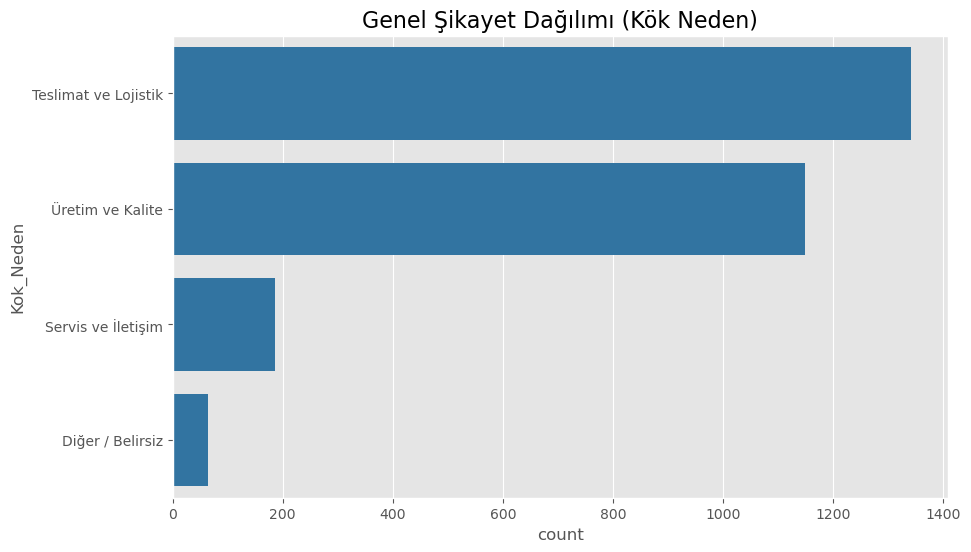

Kok_Neden
Teslimat ve Lojistik    48.959474
Üretim ve Kalite        41.913107
Servis ve İletişim       6.790800
Diğer / Belirsiz         2.336619
Name: proportion, dtype: float64


In [26]:
# Kök Neden Tanımları
root_cause_keywords = {
    "Üretim ve Kalite": [
        "çök", "kır", "yırt", "sök", "tüylen",
        "ses", "gıcır", "defo", "sol",
        "kumaş", "yay", "sünger", "deforme",
        "baza", "ayak", "leke",
        "kalite", "hata", "ayıp","çatlak","dağılma",
        "soyul", "patla", "boz", "çiz","ezik","yamuk",
        "kopma","ayrılma","kalitesiz","özensiz","dayanıksız",
        "zayıf","ince","gevşek","dikiş","işçilik","montaj",
    ],

    "Teslimat ve Lojistik": [
        "teslim", "gecik", "bekle",
        "hafta", "ay", "gün",
        "eksik", "yanlış",
        "getir", "oyala",
        "sevkiyat", "kurulum", "montaj",
        "gelme", "kargo","parça eksik","yanlış ürün","hatalı ürün geldi",
        "eksik geldi","kurmadılar","bırakıp gittiler","paket hasarlı",
        "ambalaj yırtık","koli açıktı",
    ],

    "Servis ve İletişim": [
        "servis", "ulaş","açma", "muhatap","ilgisiz", "yetkili","telefon", "iletişim",
        "saygısız", "cevap","dönüş", "teknik","yalan", "oyal","üslup", "zamanında gelmedi","süründürüyorlar",
        "aylarca","söz verdiler","erteleme","tarih değişti","bekletildim","parça yok","kimse dönmedi",
        "cevap yok","geri aramadılar","hat düşmüyor","meşgul","kapatıyorlar","umursamaz","baştan savma",
        "ilgilenmediler","geçiştirdiler","savsaklama","ciddiye almıyor","sözünde durmadı",
        "kandırıldım","oyalandım","tutarsız","çelişkili bilgi"
    ]
}

def categorize_root_cause(text):
    scores = {cat: 0 for cat in root_cause_keywords}
    for cat, keywords in root_cause_keywords.items():
        for keyword in keywords:
            if keyword in text:
                scores[cat] += 1
    
    if all(score == 0 for score in scores.values()):
        return "Diğer / Belirsiz"
    return max(scores, key=scores.get)
# Fonksiyonu Uygula
df['Kok_Neden'] = df['FullText'].apply(categorize_root_cause)
# Genel Dağılım Grafiği
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Kok_Neden', data=df, order=df['Kok_Neden'].value_counts().index)
plt.title('Genel Şikayet Dağılımı (Kök Neden)', fontsize=16)
plt.show()
# Oransal Döküm
print(df['Kok_Neden'].value_counts(normalize=True) * 100)

# 3. Derinlemesine Analizler  

Ana kategorilerin alt kırılımlarına inerek spesifik problemleri tespit ediyoruz.

- **Lojistik Detay**: *Gecikme mi yoksa ürün mü yanlış?* gibi sorunları tespit ediyoruz.
- **Kalite Detay**: *Kumaş mı yoksa iskelet mi kalitesiz?* gibi sorunları tespit ediyoruz.
- **Servis Deta**y: *Üslup mu yoksa teknik yetersizlik mi var?* gibi sorunları tespit ediyoruz.

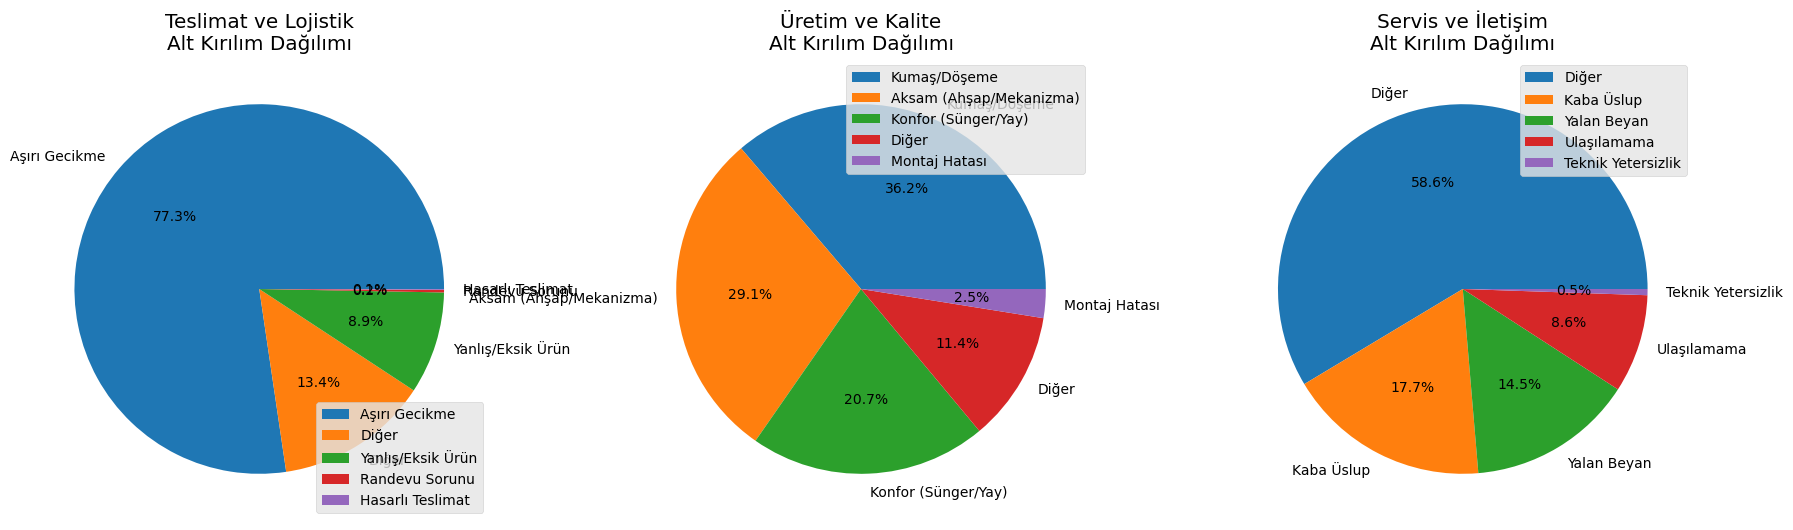

In [35]:
# --- GENİŞLETİLMİŞ ALT KIRILIM TANIMLARI ---
sub_categories_map = {
    "Teslimat ve Lojistik": {
        "Aşırı Gecikme": [
            "gelmedi", "hala gelmedi", "bekliyorum", "bekletiyorlar",
            "ay oldu", "gün oldu", "haftalar geçti",
            "tarih", "tarih verdiler", "süre", "süresi doldu",
            "gecikti", "gecikme", "ertelediler",
            "bugün yarın dediler", "oyaladılar",
            "zamanında gelmedi"
        ],
        "Yanlış/Eksik Ürün": [
            "yanlış", "yanlış ürün",
            "eksik", "eksik geldi",
            "farklı renk", "renk yanlış",
            "model farklı", "başka ürün",
            "parça eksik", "eksik parça",
            "parça yok", "hatalı ürün",
            "ürün farklı"
        ],
        "Hasarlı Teslimat": [
            "taşırken", "taşımada",
            "vurdular", "düşürdüler",
            "paket yırtık", "ambalaj hasarlı",
            "koli açık", "ezik",
            "çizik geldi", "hasarlı geldi",
            "kırık geldi", "çatlak"
        ],
        "Randevu Sorunu": [
            "bugün dediler", "yarın dediler",
            "haber vermeden", "bilgi vermeden",
            "randevu", "randevuya gelmediler",
            "arayan yok", "kimse aramadı",
            "gelmediler", "iptal ettiler"
        ]
    },

    "Üretim ve Kalite": {
        "Kumaş/Döşeme": [
            "tüylenme", "tüy yaptı",
            "yırtık", "yırtıldı",
            "sökük", "dikiş açıldı",
            "leke", "lekeli geldi",
            "renk atması", "renk verdi",
            "solma", "soldu",
            "kumaş", "kumaş kalitesi",
            "kalitesiz kumaş"
        ],
        "Konfor (Sünger/Yay)": [
            "çökme", "çöktü",
            "yay", "yay batıyor",
            "sünger", "sünger çöktü",
            "sert", "çok sert",
            "bel ağrısı", "sırt ağrısı",
            "rahatsız", "konforsuz",
            "batma", "oturulmuyor"
        ],
        "Aksam (Ahşap/Mekanizma)": [
            "kırık", "kırıldı",
            "çizik", "çizilmiş",
            "soyulma", "kaplama soyuldu",
            "kapak", "kapak yamuk",
            "menteşe", "menteşe bozuk",
            "ayak", "ayak kırık", "ayak eğri",
            "sallanma", "sallanıyor",
            "ses", "gıcırtı"
        ],
        "Montaj Hatası": [
            "montaj", "montaj hatası",
            "vida", "vida eksik",
            "eksik parça", "parça unutulmuş",
            "kurulum hatası", "yanlış montaj",
            "tam oturmamış"
        ]
    },

    "Servis ve İletişim": {
        "Kaba Üslup": [
            "bağırdı", "üstüme bağırdı",
            "kovdu", "azarladı",
            "hakaret", "hakaret etti",
            "yüzüme kapattı", "telefonu kapattı",
            "saygısız", "tersledi",
            "kaba", "lakayıt"
        ],
        "Ulaşılamama": [
            "açmıyor", "telefonu açmıyor",
            "ulaşamıyorum", "ulaşılamıyor",
            "cevap yok", "geri dönüş yok",
            "engelledi",
            "muhatap yok", "kimse yok",
            "arayan yok", "dönmediler"
        ],
        "Yalan Beyan": [
            "yalan", "yalan söylediler",
            "kandırdı", "kandırıldım",
            "geçiştirdi", "oyalıyor",
            "oyaladı", "sözünü tutmadı",
            "söz verdiler ama",
            "tutarsız bilgi"
        ],
        "Teknik Yetersizlik": [
            "yapamadı", "beceremedi",
            "anlamıyor", "bilgisi yok",
            "çözemedi", "sorun çözülmedi",
            "yanlış bilgi", "hatalı yönlendirme",
            "deneyimsiz"
        ]
    }
}

def categorize_sub_issue(text, category):
    if category not in sub_categories_map:
        return None
    
    scores = {sub: 0 for sub in sub_categories_map[category]}
    for sub, keywords in sub_categories_map[category].items():
        for kw in keywords:
            if kw in text:
                scores[sub] += 1
    
    if all(v == 0 for v in scores.values()):
        return "Diğer"
    return max(scores, key=scores.get)

# Alt Kategorileri Hesapla
df['Alt_Kirim'] = df.apply(
    lambda x: categorize_sub_issue(str(x['FullText']).lower(), x['Kok_Neden']),
    axis=1
)

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
categories = ["Teslimat ve Lojistik", "Üretim ve Kalite", "Servis ve İletişim"]

for i, cat in enumerate(categories):
    subset = df[df['Kok_Neden'] == cat]['Alt_Kirim']
    if not subset.empty:
        subset.value_counts().plot.pie(
            ax=axes[i],
            autopct='%1.1f%%',
            ylabel='',
            legend=True
        )
        axes[i].set_title(f"{cat}\nAlt Kırılım Dağılımı")

plt.show()


In [36]:
# --- ALT KIRILIMLARI TABLO OLARAK LİSTELE ---
alt_kirim_ozet = []

for cat in categories:
    subset = df[df['Kok_Neden'] == cat]['Alt_Kirim']
    if not subset.empty:
        counts = subset.value_counts(normalize=True) * 100
        for alt, pct in counts.items():
            alt_kirim_ozet.append({
                "Kök Neden": cat,
                "Alt Kırılım (Problem)": alt,
                "Yüzde (%)": round(pct, 2)
            })

alt_kirim_df = pd.DataFrame(alt_kirim_ozet)

# Kök nedene göre sıralı gösterim
alt_kirim_df = alt_kirim_df.sort_values(
    by=["Kök Neden", "Yüzde (%)"],
    ascending=[True, False]
)

alt_kirim_df


,Kök Neden,Alt Kırılım (Problem),Yüzde (%)
10,Servis ve İletişim,Diğer,58.60
11,Servis ve İletişim,Kaba Üslup,17.74
12,Servis ve İletişim,Yalan Beyan,14.52
13,Servis ve İletişim,Ulaşılamama,8.60
14,Servis ve İletişim,Teknik Yetersizlik,0.54
0,Teslimat ve Lojistik,Aşırı Gecikme,77.33
1,Teslimat ve Lojistik,Diğer,13.42
2,Teslimat ve Lojistik,Yanlış/Eksik Ürün,8.95
3,Teslimat ve Lojistik,Randevu Sorunu,0.22
4,Teslimat ve Lojistik,Hasarlı Teslimat,0.07


# 4. İleri Seviye İçgörüler #
Stratejik İçgörüler

- **Sorunlu Modeller**: Hangi ürün ailesi (Örn: Valencia, Caprice) en çok şikayet alıyor?
- **Sabır Endeksi**: Müşteriler ortalama kaç gün bekledikten sonra şikayet yazıyor?
- **Coğrafi Dağılım**: Hangi illerde sorun yoğunlaşıyor?
- **Yasal Risk**: Hangi müşteriler "Dava", "Tüketici Mahkemesi" tehdidinde bulunuyor?


--- EN PROBLEMLİ MODELLER (FİLTRELİ) ---
              Model  Sikayet_Sayisi  Yuzde (%)
0          Valencia              60       4.14
1           Estella              47       3.24
2           Larissa              43       2.97
3   Bellonavalencia              34       2.35
4           Mavenna              25       1.73
5           Loretto              22       1.52
6         Tarihinde              19       1.31
7             Nadia              17       1.17
8             Marka              17       1.17
9           Atlanta              16       1.10
10   Bellonalarissa              16       1.10
11             Plus              16       1.10
12             Mona              15       1.04
13            Bohem              14       0.97
14            Sonra              14       0.97


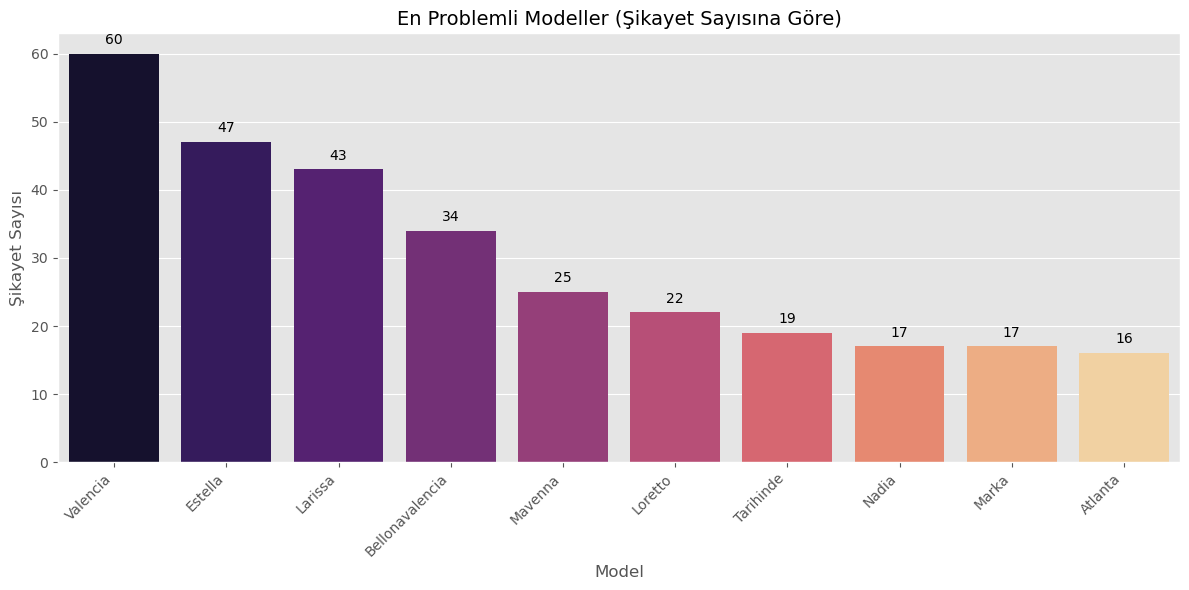

In [95]:
STOP_MODELS = {
    "aldığım", "alınan", "bir", "ve", "ile", "model","şubesinden","mağazasından",
    "salon", "oda", "takımı", "takimi", "koltuk","üçlü","kişilik","için","edilen",
    "bellona", "mobilya", "ürün", "ürünü", "dan","aldığımız","adet","edilmeyen","olan","olduğum","önce"
}

def extract_model(text):
    candidates = re.findall(
        r'\b([a-zçğıöşü]{4,})\s+(koltuk|köşe|yatak|yemek|genç|baza)\b',
        text
    )

    valid = []
    for word, _ in candidates:
        if word not in STOP_MODELS:
            valid.append(word.capitalize())

    return valid[0] if valid else None

df['Model_Tahmini'] = df['FullText'].apply(extract_model)



problemli_modeller = (
    df['Model_Tahmini']
    .dropna()
    .value_counts()
    .reset_index()
)

problemli_modeller.columns = ['Model', 'Sikayet_Sayisi']
problemli_modeller['Yuzde (%)'] = (
    problemli_modeller['Sikayet_Sayisi'] /
    problemli_modeller['Sikayet_Sayisi'].sum() * 100
).round(2)

print("\n--- EN PROBLEMLİ MODELLER (FİLTRELİ) ---")
print(problemli_modeller.head(15))


TOP_N = 10
top_models = problemli_modeller.head(TOP_N)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_models,
    x='Model',
    y='Sikayet_Sayisi',
    palette='magma'
)

plt.title('En Problemli Modeller (Şikayet Sayısına Göre)', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Şikayet Sayısı')
plt.xticks(rotation=45, ha='right')

# Bar üstüne değer yaz
for index, row in top_models.iterrows():
    plt.text(
        top_models.index.get_loc(index),
        row['Sikayet_Sayisi'] + 1,
        int(row['Sikayet_Sayisi']),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# SABIR ENDEKSİ
Bu bölümde "*Ürünü satın alanlar ortalama kaç gün sonra şikate etmeye başlıyorlar*" sorusuna cevap arıyoruz.



--- SABIR ENDEKSİ ---
Müşteriler ortalama 81.5 gün bekledikten sonra şikâyet yazıyor.


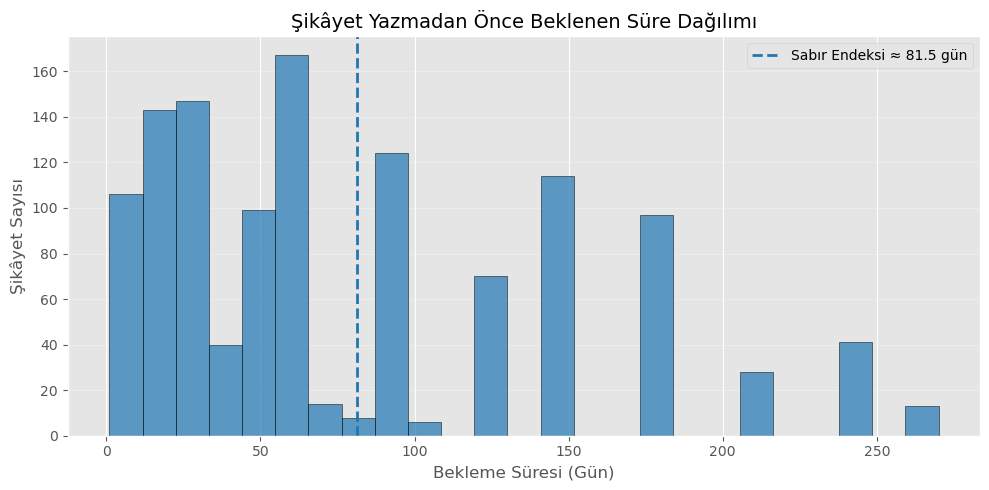

In [96]:
import numpy as np
import re

def extract_wait_days(text):
    days = []

    gun = re.findall(r'(\d+)\s*gün', text)
    hafta = re.findall(r'(\d+)\s*hafta', text)
    ay = re.findall(r'(\d+)\s*ay', text)

    days += [int(g) for g in gun]
    days += [int(h) * 7 for h in hafta]
    days += [int(a) * 30 for a in ay]

    # Mantıksız büyük süreleri ele (örn: garanti süresi)
    days = [d for d in days if 0 < d < 300]

    return max(days) if days else None

df['Bekleme_Suresi_Gun'] = df['FullText'].apply(extract_wait_days)

sabir_endeksi = df['Bekleme_Suresi_Gun'].mean()

print(f"\n--- SABIR ENDEKSİ ---")
print(f"Müşteriler ortalama {sabir_endeksi:.1f} gün bekledikten sonra şikâyet yazıyor.")



plt.figure(figsize=(10, 5))

valid_waits = df['Bekleme_Suresi_Gun'].dropna()

plt.hist(valid_waits, bins=25, edgecolor='black', alpha=0.7)

# Sabır Endeksi çizgisi
plt.axvline(
    sabir_endeksi,
    linestyle='--',
    linewidth=2,
    label=f'Sabır Endeksi ≈ {sabir_endeksi:.1f} gün'
)

plt.title('Şikâyet Yazmadan Önce Beklenen Süre Dağılımı', fontsize=14)
plt.xlabel('Bekleme Süresi (Gün)')
plt.ylabel('Şikâyet Sayısı')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Şikayetlerin İllere Göre Dağılımı
Bu bölümde şiakeytlerin illere göre dağılımını analiz ediyoruz.


--- COĞRAFİ DAĞILIM ---
           Il  Sikayet_Sayisi  Yuzde (%)
0     Stanbul             208      12.40
1      Ankara             192      11.45
2         Muş             153       9.12
3        Ağrı             107       6.38
4        Ordu             103       6.14
5        Zmir              93       5.55
6  Diyarbakır              60       3.58
7     Kayseri              45       2.68
8       Aydın              40       2.39
9       Konya              39       2.33


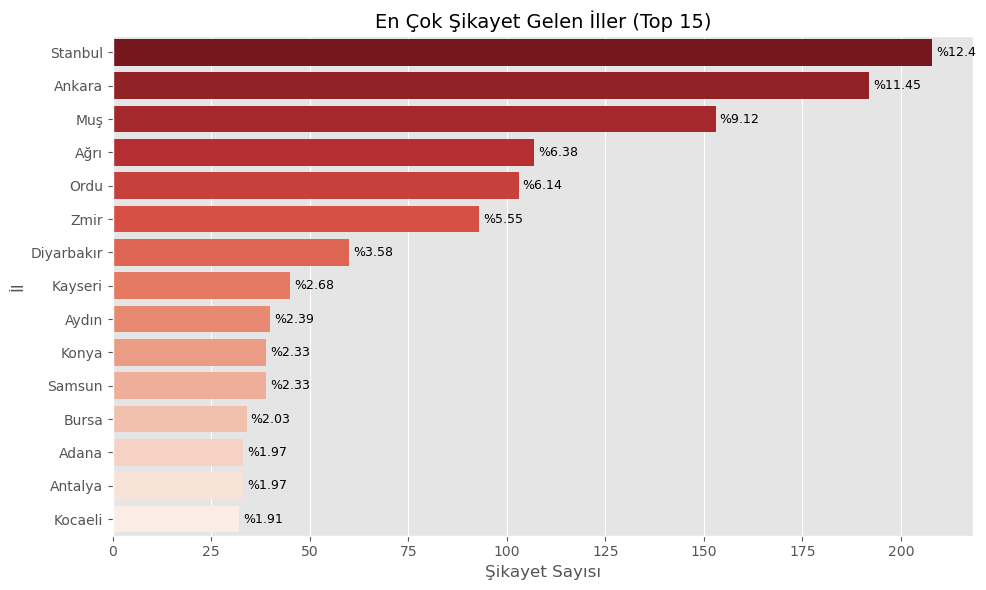

In [98]:
ILLER = [
    "adana", "adıyaman", "afyon", "ağrı", "amasya", "ankara", "antalya", "artvin", "aydın", "balıkesir",
    "bilecik", "bingöl", "bitlis", "bolu", "burdur", "bursa", "çanakkale", "çankırı", "çorum", "denizli",
    "diyarbakır", "edirne", "elazığ", "erzincan", "erzurum", "eskişehir", "gaziantep", "giresun", "gümüşhane",
    "hakkari", "hatay", "sparta", "mersin", "stanbul", "zmir", "kars", "kastamonu", "kayseri", "kırklareli",
    "kırşehir", "kocaeli", "konya", "kütahya", "malatya", "manisa", "kahramanmaraş", "mardin", "muğla", "muş",
    "nevşehir", "niğde", "ordu", "rize", "sakarya", "samsun", "siirt", "sinop", "sivas", "tekirdağ", "tokat",
    "trabzon", "tunceli", "şanlıurfa", "uşak", "van", "yozgat", "zonguldak", "aksaray", "bayburt", "karaman",
    "kırıkkale", "batman", "şırnak", "bartın", "ardahan", "ığdır", "yalova", "karabük", "kilis", "osmaniye", "düzce"
]


def extract_city(text):
    for il in ILLER:
        if il in text:
            return il.capitalize()
    return None

df['Il_Tahmini'] = df['FullText'].apply(extract_city)

il_dagilim = df['Il_Tahmini'].value_counts().reset_index()
il_dagilim.columns = ['Il', 'Sikayet_Sayisi']

il_dagilim['Yuzde (%)'] = (
    il_dagilim['Sikayet_Sayisi'] /
    il_dagilim['Sikayet_Sayisi'].sum() * 100
).round(2)

print("\n--- COĞRAFİ DAĞILIM ---")
print(il_dagilim.head(10))


import matplotlib.pyplot as plt
import seaborn as sns

# En çok şikayet gelen 15 il
top_il = il_dagilim.head(15)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_il,
    x='Sikayet_Sayisi',
    y='Il',
    palette='Reds_r'
)

plt.title('En Çok Şikayet Gelen İller (Top 15)', fontsize=14)
plt.xlabel('Şikayet Sayısı')
plt.ylabel('İl')

# Çubukların yanına yüzde yaz
for i, row in top_il.iterrows():
    ax.text(
        row['Sikayet_Sayisi'] + 1,
        i,
        f"%{row['Yuzde (%)']}",
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()



# Yasal Risk Durumu
Bu bölümde yasal risk ile ilgili durumlar analiz ediyoruz. Yasal risk **en öncelikli** ele alınması gereken konudur. Dikkat edilmezse hem müşteri kaybına hem de maddi zararlara neden olabilir. Yorumlardan yasal tehdit içerenler belirlenmektedir.


--- YASAL RİSK ANALİZİ ---
Yasal tehdit içeren şikâyet sayısı: 228
Oran: %8.32


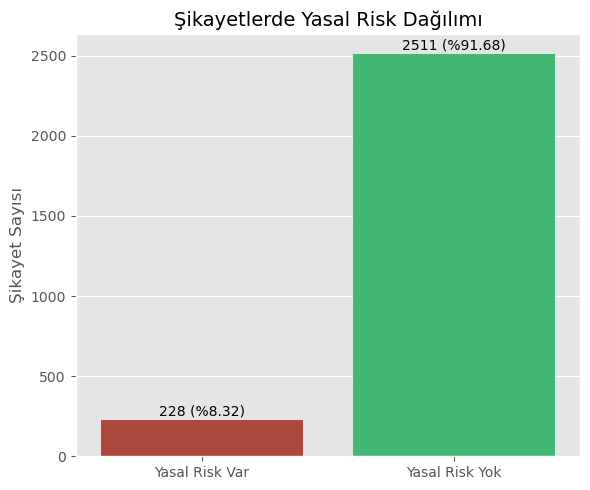

In [99]:
YASAL_KELIMELER = [
    "dava", "mahkeme", "tüketici hakem",
    "tüketici mahkemesi", "avukat", "hukuki işlem",
    "cimer", "savcılık"
]

def detect_legal_risk(text):
    for kw in YASAL_KELIMELER:
        if kw in text:
            return True
    return False

df['Yasal_Risk'] = df['FullText'].apply(detect_legal_risk)

riskli_sayisi = df['Yasal_Risk'].sum()
toplam = len(df)

print("\n--- YASAL RİSK ANALİZİ ---")
print(f"Yasal tehdit içeren şikâyet sayısı: {riskli_sayisi}")
print(f"Oran: %{(riskli_sayisi / toplam * 100):.2f}")


# Grafik için veri hazırla
risk_df = pd.DataFrame({
    'Durum': ['Yasal Risk Var', 'Yasal Risk Yok'],
    'Sayi': [riskli_sayisi, toplam - riskli_sayisi]
})

risk_df['Yuzde (%)'] = (risk_df['Sayi'] / toplam * 100).round(2)

# Grafik
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=risk_df,
    x='Durum',
    y='Sayi',
    palette=['#c0392b', '#2ecc71']
)

plt.title('Şikayetlerde Yasal Risk Dağılımı', fontsize=14)
plt.ylabel('Şikayet Sayısı')
plt.xlabel('')

# Yüzde ve sayı etiketleri
for i, row in risk_df.iterrows():
    ax.text(
        i,
        row['Sayi'] + toplam * 0.01,
        f"{row['Sayi']} (%{row['Yuzde (%)']})",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

## Model Risk Profili
Bu bölümde kök nedenler bazında bekleme süresi ve şikayet sayısına dayalı olarak ortalama bekleme süreleri ve **risk oranı** hesaplanmıştır.

In [101]:

aksiyon_tablosu = (
    df.groupby('Kok_Neden')
    .agg(
        Sikayet_Sayisi=('Kok_Neden', 'count'),
        Ortalama_Bekleme_Gunu=('Bekleme_Suresi_Gun', 'mean'),
        Yasal_Risk_Sayisi=('Yasal_Risk', 'sum')
    )
    .reset_index()
)

aksiyon_tablosu['Yasal_Risk_Orani (%)'] = (
    aksiyon_tablosu['Yasal_Risk_Sayisi'] /
    aksiyon_tablosu['Sikayet_Sayisi'] * 100
).round(2)

aksiyon_tablosu = aksiyon_tablosu.sort_values(
    by='Yasal_Risk_Orani (%)',
    ascending=False
)

print("\n--- AKSİYON ODAKLI KÖK NEDEN TABLOSU ---")
print(aksiyon_tablosu)



--- AKSİYON ODAKLI KÖK NEDEN TABLOSU ---
              Kok_Neden  Sikayet_Sayisi  Ortalama_Bekleme_Gunu  \
3      Üretim ve Kalite            1148             107.804511   
1    Servis ve İletişim             186              79.623377   
2  Teslimat ve Lojistik            1341              67.484480   
0      Diğer / Belirsiz              64                    NaN   

   Yasal_Risk_Sayisi  Yasal_Risk_Orani (%)  
3                118                 10.28  
1                 19                 10.22  
2                 91                  6.79  
0                  0                  0.00  


posx and posy should be finite values
posx and posy should be finite values


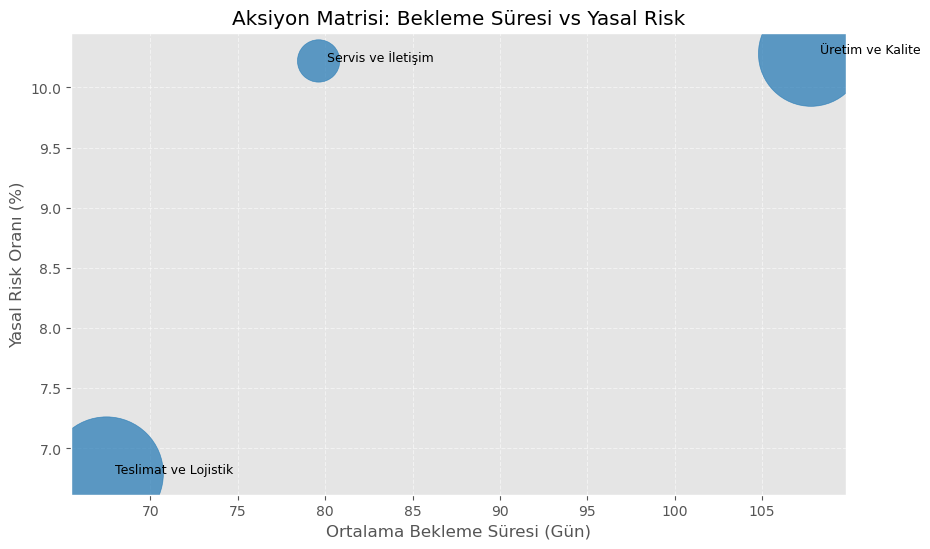

In [102]:
plt.figure(figsize=(10, 6))

plt.scatter(
    aksiyon_tablosu['Ortalama_Bekleme_Gunu'],
    aksiyon_tablosu['Yasal_Risk_Orani (%)'],
    s=aksiyon_tablosu['Sikayet_Sayisi'] * 5,
    alpha=0.7
)

for _, row in aksiyon_tablosu.iterrows():
    plt.text(
        row['Ortalama_Bekleme_Gunu'] + 0.5,
        row['Yasal_Risk_Orani (%)'],
        row['Kok_Neden'],
        fontsize=9
    )

plt.xlabel('Ortalama Bekleme Süresi (Gün)')
plt.ylabel('Yasal Risk Oranı (%)')
plt.title('Aksiyon Matrisi: Bekleme Süresi vs Yasal Risk')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


**Yorum:** Şekilde sunulan aksiyon matrisi, müşteri şikâyetlerinde ortalama bekleme süresi ile yasal risk oranı arasındaki ilişkiyi üç temel problem alanı (Teslimat ve Lojistik, Servis ve İletişim, Üretim ve Kalite) üzerinden görselleştirmektedir. Grafikte yatay eksen müşterilerin şikâyet yazmadan önce ortalama kaç gün beklediğini, dikey eksen ise hukuki tehdit (**dava, tüketici mahkemesi vb.**) içeren şikâyetlerin oranını göstermektedir. Balon büyüklükleri ilgili kategoriye ait şikâyet hacmini temsil etmektedir.

Grafik incelendiğinde Üretim ve Kalite kategorisinin hem en uzun bekleme süresine hem de en yüksek yasal risk oranına sahip olduğu görülmektedir. Bu durum, üretim ve kalite kaynaklı sorunların müşteriler açısından yalnızca operasyonel bir aksaklık olarak değil, doğrudan hukuki süreç başlatma gerekçesi olarak algılandığını göstermektedir. Aynı zamanda balon büyüklüğünün yüksek olması, bu riskin sınırlı sayıda müşteriyle değil, geniş bir kullanıcı kitlesiyle ilişkili olduğunu ortaya koymaktadır.

Servis ve İletişim kategorisi ise bekleme süresi bakımından orta seviyede olmasına rağmen, yasal risk oranının oldukça yüksek olduğu bir alan olarak dikkat çekmektedir. Bu bulgu, hukuki tehditlerin yalnızca bekleme süresinin uzunluğundan değil, süreç boyunca müşteriye sunulan bilgilendirme ve iletişim kalitesinden de güçlü biçimde etkilendiğini göstermektedir. Özellikle geri dönüş eksikliği ve belirsizlik, müşterilerin daha kısa sürede yasal söylemlere yönelmesine neden olmaktadır.

Teslimat ve Lojistik kategorisinde ise görece daha kısa bekleme sürelerine rağmen şikâyet hacminin yüksek olduğu, ancak yasal risk oranının diğer alanlara kıyasla daha düşük kaldığı görülmektedir. Bu durum, teslimat kaynaklı sorunların yaygın olmakla birlikte henüz yüksek düzeyde hukuki tehdit üretmediğini ve erken müdahale ile kontrol altına alınabilecek bir risk alanı sunduğunu göstermektedir.

Genel olarak grafik, yasal riskin yalnızca bekleme süresinin uzunluğuna bağlı olmadığını, müşteri deneyiminin bütüncül niteliği — özellikle iletişim ve şeffaflık düzeyi — tarafından belirlendiğini ortaya koymaktadır. Uzun bekleme süreleri ile yetersiz iletişimin birleştiği alanlarda yasal riskin belirgin biçimde arttığı, bu nedenle bu alanların öncelikli aksiyon gerektiren kritik bölgeler olduğu sonucuna varılmaktadır.

# Darboğaz Tahmini (Müşteri Kaybı Analizi)

In [103]:
# Darboğaz tanımı:
# 1) Bekleme süresi uzun
# 2) Aynı anda servis / iletişim problemi var
# 3) Şikayet çözülmemiş hissi

DARBOGAZ_ALT_KIRIMLAR = [
    "Aşırı Gecikme",
    "Ulaşılamama",
    "Yalan Beyan",
    "Teknik Yetersizlik"
]

# Bekleme süresi eşiği (istatistiksel)
bekleme_esik = df['Bekleme_Suresi_Gun'].quantile(0.75)

df['Darbogaz'] = df.apply(
    lambda x: (
        x['Bekleme_Suresi_Gun'] is not None and
        x['Bekleme_Suresi_Gun'] >= bekleme_esik and
        x['Alt_Kirim'] in DARBOGAZ_ALT_KIRIMLAR
    ),
    axis=1
)

print("Darboğaz oluşturan kayıt sayısı:", df['Darbogaz'].sum())


Darboğaz oluşturan kayıt sayısı: 127


In [104]:
darbogaz_ozet = (
    df[df['Darbogaz']]
    .groupby(['Kok_Neden', 'Alt_Kirim'])
    .size()
    .reset_index(name='Sayi')
    .sort_values('Sayi', ascending=False)
)

print("\n--- DARBOĞAZ OLUŞUM NOKTALARI ---")
print(darbogaz_ozet.head(10))



--- DARBOĞAZ OLUŞUM NOKTALARI ---
              Kok_Neden      Alt_Kirim  Sayi
2  Teslimat ve Lojistik  Aşırı Gecikme   125
0    Servis ve İletişim    Ulaşılamama     1
1    Servis ve İletişim    Yalan Beyan     1


In [105]:
df['Musteri_Kaybi_Riski'] = df.apply(
    lambda x: (
        x['Yasal_Risk'] == True and
        x['Bekleme_Suresi_Gun'] is not None and
        x['Bekleme_Suresi_Gun'] >= bekleme_esik
    ),
    axis=1
)

print("Müşteri kaybı riski taşıyan kayıt:", df['Musteri_Kaybi_Riski'].sum())


Müşteri kaybı riski taşıyan kayıt: 53


In [106]:
kayip_eylem_analizi = (
    df[df['Musteri_Kaybi_Riski']]
    .groupby(['Kok_Neden', 'Alt_Kirim'])
    .size()
    .reset_index(name='Kayip_Risk_Sayisi')
    .sort_values('Kayip_Risk_Sayisi', ascending=False)
)

print("\n--- MÜŞTERİ KAYBINA NEDEN OLAN EYLEMLER ---")
print(kayip_eylem_analizi.head(10))



--- MÜŞTERİ KAYBINA NEDEN OLAN EYLEMLER ---
              Kok_Neden                Alt_Kirim  Kayip_Risk_Sayisi
8      Üretim ve Kalite             Kumaş/Döşeme                 15
3  Teslimat ve Lojistik            Aşırı Gecikme                 13
7      Üretim ve Kalite      Konfor (Sünger/Yay)                 10
5      Üretim ve Kalite  Aksam (Ahşap/Mekanizma)                  7
6      Üretim ve Kalite                    Diğer                  4
0    Servis ve İletişim                    Diğer                  1
1    Servis ve İletişim              Ulaşılamama                  1
2    Servis ve İletişim              Yalan Beyan                  1
4  Teslimat ve Lojistik                    Diğer                  1


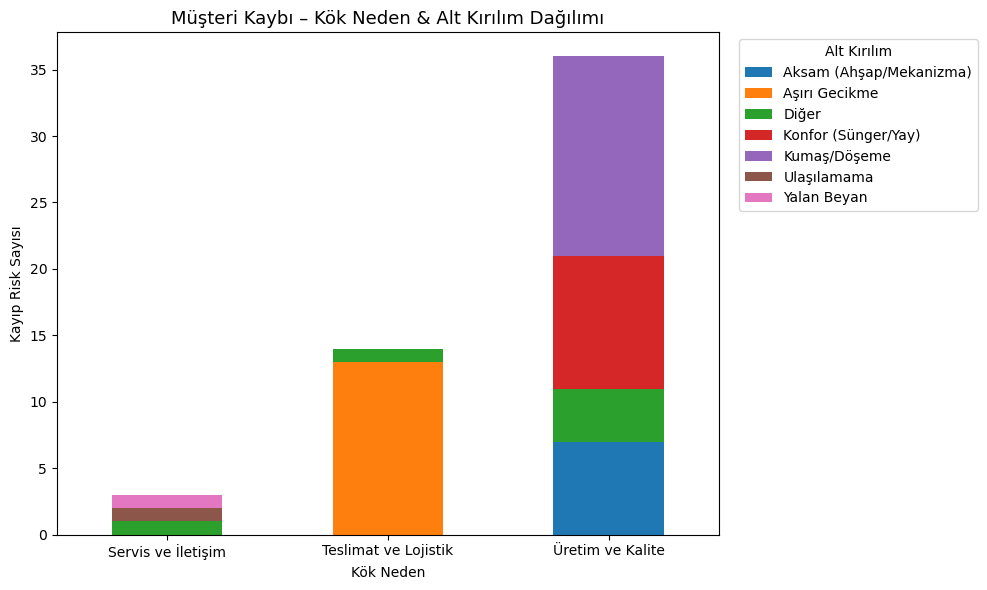

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Veriyi oluştur
# -----------------------------
data = {
    "Kok_Neden": [
        "Üretim ve Kalite",
        "Teslimat ve Lojistik",
        "Üretim ve Kalite",
        "Üretim ve Kalite",
        "Üretim ve Kalite",
        "Servis ve İletişim",
        "Servis ve İletişim",
        "Servis ve İletişim",
        "Teslimat ve Lojistik"
    ],
    "Alt_Kirim": [
        "Kumaş/Döşeme",
        "Aşırı Gecikme",
        "Konfor (Sünger/Yay)",
        "Aksam (Ahşap/Mekanizma)",
        "Diğer",
        "Diğer",
        "Ulaşılamama",
        "Yalan Beyan",
        "Diğer"
    ],
    "Kayip_Risk_Sayisi": [15, 13, 10, 7, 4, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# -----------------------------
# 2) Pivot tablo: 
#    satır = Kök Neden
#    sütun = Alt Kırılım
# -----------------------------
pivot = df.pivot_table(
    index="Kok_Neden",
    columns="Alt_Kirim",
    values="Kayip_Risk_Sayisi",
    aggfunc="sum",
    fill_value=0
)

# -----------------------------
# 3) Stacked Bar Chart çiz
# -----------------------------
ax = pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

ax.set_title("Müşteri Kaybı – Kök Neden & Alt Kırılım Dağılımı", fontsize=13)
ax.set_xlabel("Kök Neden")
ax.set_ylabel("Kayıp Risk Sayısı")

plt.xticks(rotation=0)
plt.legend(title="Alt Kırılım", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Alt Kırılma Göre Müşteri Kaybı Riski
Bu bölümde kök nedenlerin alt kırılımlarına dayalı olarak müşteri kaybı riski analiz edilmektedir.

In [107]:
alt_kirim_toplam = df.groupby('Alt_Kirim').size()
alt_kirim_kayip = df[df['Musteri_Kaybi_Riski']].groupby('Alt_Kirim').size()

risk_orani = (
    (alt_kirim_kayip / alt_kirim_toplam)
    .dropna()
    .sort_values(ascending=False)
    * 100
)

print("\n--- ALT KIRILIM BAZLI MÜŞTERİ KAYBI RİSKİ (%) ---")
print(risk_orani.round(2).head(10))



--- ALT KIRILIM BAZLI MÜŞTERİ KAYBI RİSKİ (%) ---
Alt_Kirim
Ulaşılamama                6.25
Konfor (Sünger/Yay)        4.20
Yalan Beyan                3.70
Kumaş/Döşeme               3.61
Aksam (Ahşap/Mekanizma)    2.10
Diğer                      1.43
Aşırı Gecikme              1.25
dtype: float64


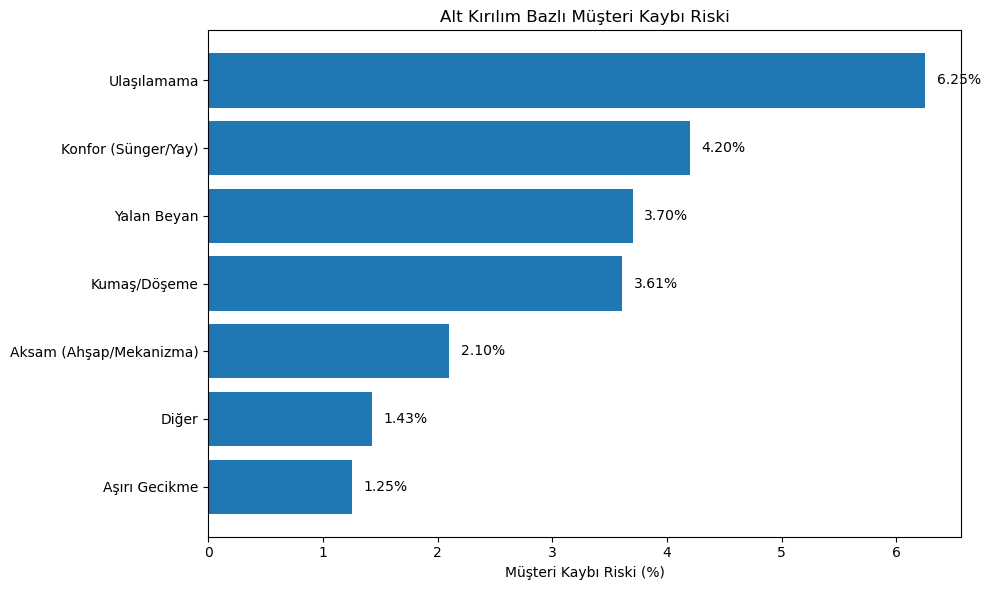

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Veriyi oluştur
# -----------------------------
data = {
    "Alt_Kirim": [
        "Ulaşılamama",
        "Konfor (Sünger/Yay)",
        "Yalan Beyan",
        "Kumaş/Döşeme",
        "Aksam (Ahşap/Mekanizma)",
        "Diğer",
        "Aşırı Gecikme"
    ],
    "Risk_Yuzde": [6.25, 4.20, 3.70, 3.61, 2.10, 1.43, 1.25]
}

df = pd.DataFrame(data)

# -----------------------------
# 2) Büyükten küçüğe sırala
# -----------------------------
df = df.sort_values("Risk_Yuzde", ascending=True)

# -----------------------------
# 3) Yatay bar chart çiz
# -----------------------------
plt.figure(figsize=(10, 6))
plt.barh(df["Alt_Kirim"], df["Risk_Yuzde"])
plt.xlabel("Müşteri Kaybı Riski (%)")
plt.title("Alt Kırılım Bazlı Müşteri Kaybı Riski")

# Bar üstüne yüzde yaz
for index, value in enumerate(df["Risk_Yuzde"]):
    plt.text(value + 0.1, index, f"{value:.2f}%", va="center")

plt.tight_layout()
plt.show()


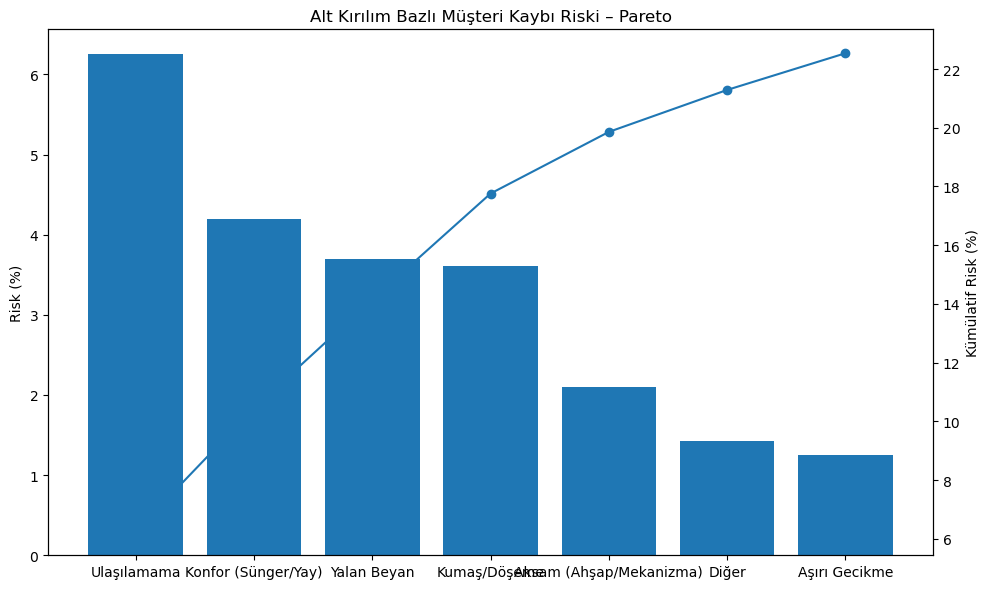

In [25]:
import numpy as np

df_desc = df.sort_values("Risk_Yuzde", ascending=False)
df_desc["Kumulatif_%"] = df_desc["Risk_Yuzde"].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(df_desc["Alt_Kirim"], df_desc["Risk_Yuzde"])
ax1.set_ylabel("Risk (%)")
ax1.set_title("Alt Kırılım Bazlı Müşteri Kaybı Riski – Pareto")

ax2 = ax1.twinx()
ax2.plot(df_desc["Alt_Kirim"], df_desc["Kumulatif_%"], marker="o")
ax2.set_ylabel("Kümülatif Risk (%)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Müşteri Kaybı (Churn) Tahmin Modeli

**Amaç**: “Bu şikâyet müşteri kaybına gider mi?” sorusunu şikâyet yazıldığı anda tahmin etmek.

In [109]:
import pandas as pd
import numpy as np

# Binary feature'lar
df_ml = df.copy()

df_ml['Uzun_Bekleme'] = df_ml['Bekleme_Suresi_Gun'].apply(
    lambda x: 1 if x is not None and x >= bekleme_esik else 0
)

df_ml['Servis_Sorunu'] = df_ml['Alt_Kirim'].isin([
    "Ulaşılamama", "Yalan Beyan", "Teknik Yetersizlik", "Kaba Üslup"
]).astype(int)

df_ml['Teslimat_Sorunu'] = df_ml['Alt_Kirim'].isin([
    "Aşırı Gecikme", "Yanlış/Eksik Ürün", "Hasarlı Teslimat", "Randevu Sorunu"
]).astype(int)

df_ml['Uretim_Sorunu'] = df_ml['Kok_Neden'].eq("Üretim ve Kalite").astype(int)

df_ml['Yasal_Risk'] = df_ml['Yasal_Risk'].astype(int)

# Hedef değişken
df_ml['Churn'] = df_ml['Musteri_Kaybi_Riski'].astype(int)

df_ml[['Uzun_Bekleme','Servis_Sorunu','Teslimat_Sorunu','Uretim_Sorunu','Yasal_Risk','Churn']].head()


,Uzun_Bekleme,Servis_Sorunu,Teslimat_Sorunu,Uretim_Sorunu,Yasal_Risk,Churn
0,0,0,0,1,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [110]:
FEATURES = [
    'Uzun_Bekleme',
    'Servis_Sorunu',
    'Teslimat_Sorunu',
    'Uretim_Sorunu',
    'Yasal_Risk'
]

X = df_ml[FEATURES]
y = df_ml['Churn']


In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))


[[672   0]
 [  0  13]]

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       1.00      1.00      1.00        13

    accuracy                           1.00       685
   macro avg       1.00      1.00      1.00       685
weighted avg       1.00      1.00      1.00       685



In [117]:
importance = pd.DataFrame({
    'Feature': FEATURES,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\n--- MÜŞTERİ KAYBINI TETİKLEYEN FAKTÖRLER ---")
print(importance)



--- MÜŞTERİ KAYBINI TETİKLEYEN FAKTÖRLER ---
           Feature  Coefficient
4       Yasal_Risk     7.047766
0     Uzun_Bekleme     6.486746
3    Uretim_Sorunu     0.440268
1    Servis_Sorunu     0.221164
2  Teslimat_Sorunu    -0.017781


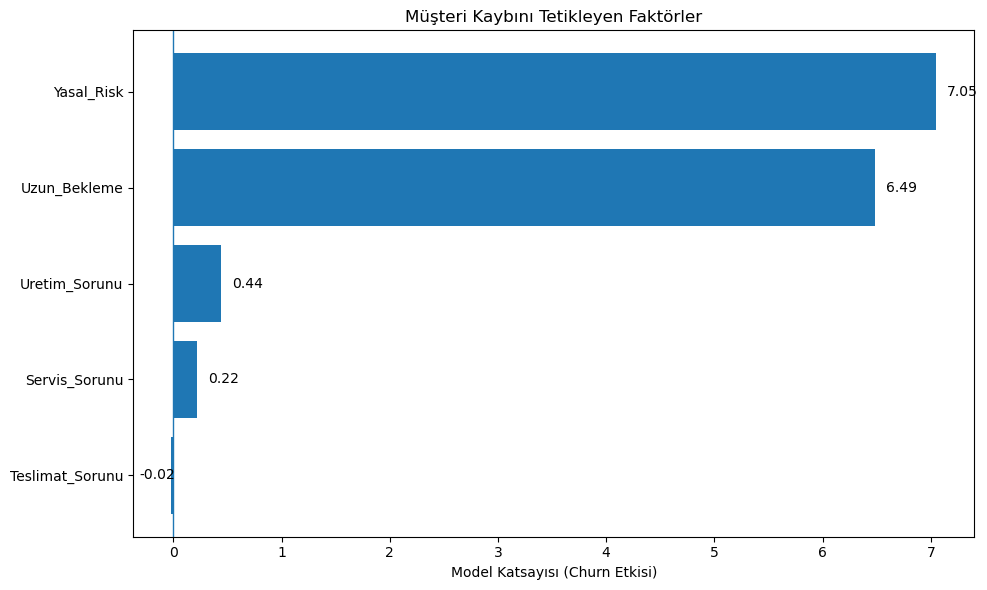

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Veriyi oluştur
# -----------------------------
data = {
    "Feature": [
        "Yasal_Risk",
        "Uzun_Bekleme",
        "Uretim_Sorunu",
        "Servis_Sorunu",
        "Teslimat_Sorunu"
    ],
    "Coefficient": [7.047766, 6.486746, 0.440268, 0.221164, -0.017781]
}

df = pd.DataFrame(data)

# -----------------------------
# 2) Büyükten küçüğe sırala
# -----------------------------
df = df.sort_values("Coefficient")

# -----------------------------
# 3) Yatay bar chart çiz
# -----------------------------
plt.figure(figsize=(10, 6))
bars = plt.barh(df["Feature"], df["Coefficient"])

plt.xlabel("Model Katsayısı (Churn Etkisi)")
plt.title("Müşteri Kaybını Tetikleyen Faktörler")

# Pozitif / negatif ayırımı için dikey sıfır çizgisi
plt.axvline(0, linewidth=1)

# Bar üstüne değer yaz
for index, value in enumerate(df["Coefficient"]):
    plt.text(
        value + (0.1 if value >= 0 else -0.3),
        index,
        f"{value:.2f}",
        va="center"
    )

plt.tight_layout()
plt.show()


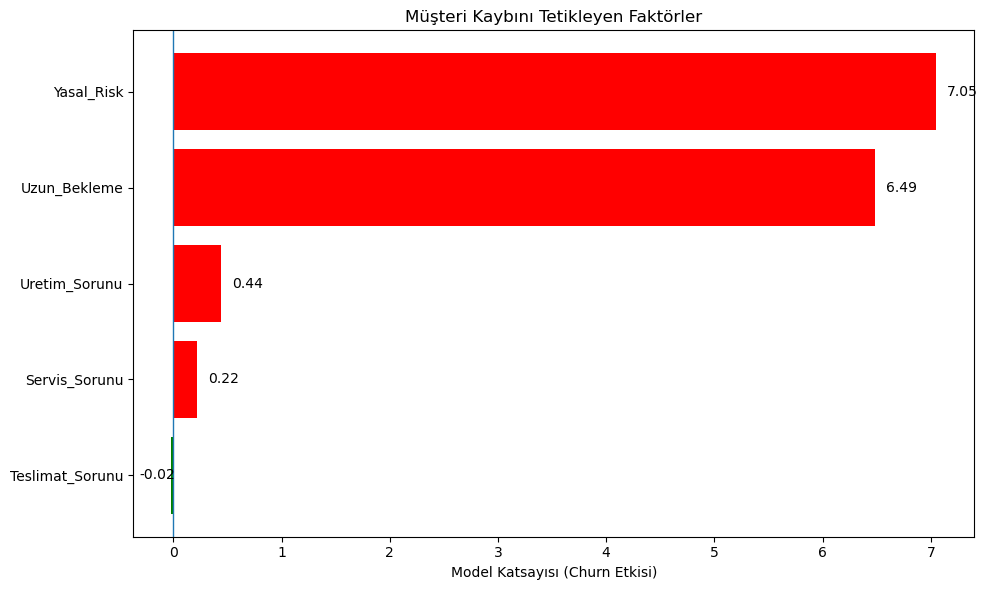

In [29]:
colors = ["red" if c > 0 else "green" for c in df["Coefficient"]]

plt.figure(figsize=(10, 6))
plt.barh(df["Feature"], df["Coefficient"], color=colors)

plt.xlabel("Model Katsayısı (Churn Etkisi)")
plt.title("Müşteri Kaybını Tetikleyen Faktörler")

plt.axvline(0, linewidth=1)

for index, value in enumerate(df["Coefficient"]):
    plt.text(
        value + (0.1 if value >= 0 else -0.3),
        index,
        f"{value:.2f}",
        va="center"
    )

plt.tight_layout()
plt.show()


In [119]:
df_ml['Churn_Olasiligi'] = model.predict_proba(X)[:,1]

df_ml[['Churn_Olasiligi','Alt_Kirim','Kok_Neden','Bekleme_Suresi_Gun']].sort_values(
    'Churn_Olasiligi', ascending=False
).head(10)


def churn_alarm(row):
    if row['Churn_Olasiligi'] >= 0.8:
        return "🔴 ACİL MÜDAHALE"
    elif row['Churn_Olasiligi'] >= 0.5:
        return "🟠 TAKİP GEREKİYOR"
    else:
        return "🟢 NORMAL"

df_ml['Alarm_Seviyesi'] = df_ml.apply(churn_alarm, axis=1)

df_ml['Alarm_Seviyesi'].value_counts()


Alarm_Seviyesi
🟢 NORMAL           2686
🔴 ACİL MÜDAHALE      53
Name: count, dtype: int64

# Hangi eylemi yaparsak müşteri kaybı en çok azalır?


In [120]:
df_action = df_ml.copy()

df_action['Churn_Prob_Baslangic'] = model.predict_proba(
    df_action[FEATURES]
)[:,1]

df_action['Churn_Prob_Baslangic'].mean()


0.031928532061333406

In [121]:
def simulate_action(df, feature_name):
    df_sim = df.copy()
    
    # İlgili problemi çözdüğümüzü varsay
    df_sim[feature_name] = 0
    
    new_probs = model.predict_proba(
        df_sim[FEATURES]
    )[:,1]
    
    return df['Churn_Prob_Baslangic'].mean() - new_probs.mean()


In [122]:
action_impact = []

for feature in FEATURES:
    impact = simulate_action(df_action, feature)
    action_impact.append({
        'Eylem': feature,
        'Churn_Azalis_Etkisi': round(impact, 4)
    })

impact_df = pd.DataFrame(action_impact).sort_values(
    'Churn_Azalis_Etkisi', ascending=False
)

print("\n--- EYLEM → MÜŞTERİ KAYBI AZALIŞ ETKİSİ ---")
impact_df



--- EYLEM → MÜŞTERİ KAYBI AZALIŞ ETKİSİ ---


,Eylem,Churn_Azalis_Etkisi
4,Yasal_Risk,0.0241
0,Uzun_Bekleme,0.0236
3,Uretim_Sorunu,0.0026
1,Servis_Sorunu,0.0001
2,Teslimat_Sorunu,-0.0001


In [123]:
eylem_map = {
    'Uzun_Bekleme': 'Teslim süresi kısaltma / gerçek tarih verme',
    'Servis_Sorunu': 'İlk 24 saat içinde müşteriyle temas',
    'Teslimat_Sorunu': 'Teslimat kontrol checklist',
    'Uretim_Sorunu': 'Problemli model üretim denetimi',
    'Yasal_Risk': 'Proaktif hukuki çözüm / iade'
}

impact_df['Operasyonel_Eylem'] = impact_df['Eylem'].map(eylem_map)
impact_df


,Eylem,Churn_Azalis_Etkisi,Operasyonel_Eylem
4,Yasal_Risk,0.0241,Proaktif hukuki çözüm / iade
0,Uzun_Bekleme,0.0236,Teslim süresi kısaltma / gerçek tarih verme
3,Uretim_Sorunu,0.0026,Problemli model üretim denetimi
1,Servis_Sorunu,0.0001,İlk 24 saat içinde müşteriyle temas
2,Teslimat_Sorunu,-0.0001,Teslimat kontrol checklist
